In [1]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt
from matplotlib import cm

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR, OjaRNN, Linear
import configs
from eval import eval

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [9]:
num_steps = 3000
num_states = 25

In [10]:
datasets = [ 
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[4,1,1]),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[1,1,4]),
    ]

# Run models

In [18]:
def run_models():
    t_errors = []
    m_errors = []
    row_norms = []
    labels = []
    colors = []

    net = STDP_SR(2, 0.4)
    t_error, m_error, row_norm, _ = eval(
        net, datasets
        )
    t_errors.append(np.mean(t_error, axis=0))
    m_errors.append(np.mean(m_error, axis=0))
    row_norms.append(np.mean(row_norm, axis=0))
    labels.append(f'None')
    colors.append('C0')
    
    net = STDP_SR(2, 0.4, ca3_kwargs={
        'output_params':{'num_iterations': 51,'nonlinearity': 'tanh',
                         'nonlinearity_args': 2.}
        })
    t_error, m_error, row_norm, _ = eval(
        net, datasets
        )
    t_errors.append(np.mean(t_error, axis=0))
    m_errors.append(np.mean(m_error, axis=0))
    row_norms.append(np.mean(row_norm, axis=0))
    labels.append(f'Tanh 2')
    colors.append('C1')
    
    net = STDP_SR(2, 0.4, ca3_kwargs={
    'output_params':{'num_iterations': 51,'nonlinearity': 'tanh',
                     'nonlinearity_args': 1.}
        })
    t_error, m_error, row_norm, _ = eval(
        net, datasets
        )
    t_errors.append(np.mean(t_error, axis=0))
    m_errors.append(np.mean(m_error, axis=0))
    row_norms.append(np.mean(row_norm, axis=0))
    labels.append(f'Tanh 1')
    colors.append('C2')

    return t_errors, m_errors, row_norms, labels, colors

In [19]:
t_errors, m_errors, row_norms, labels, colors = run_models()
data = {}
data['t_errors'] = t_errors
data['m_errors'] = m_errors
data['row_norms'] = row_norms
data['labels'] = labels
data['colors'] = colors

# Make plots

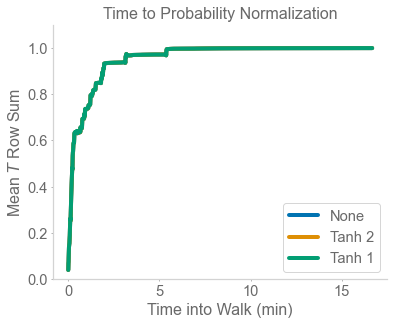

In [20]:
plt.figure(figsize=(6.4*0.9, 4.8))
for idx in range(len(labels)):
    if labels[idx] is not None and 'TD' in labels[idx]: continue
    y = row_norms[idx]
    x = np.arange(y.size)/configs.dt_to_sec/60
    plt.plot(
        x, y, label=labels[idx],
        linewidth=4, color=colors[idx]
        )
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('Time into Walk (min)')
plt.ylabel('Mean $T$ Row Sum')
plt.title('Time to Probability Normalization')
plt.tight_layout()
#plt.savefig('1f_oja_norm_sum.png', dpi=300)
plt.show()

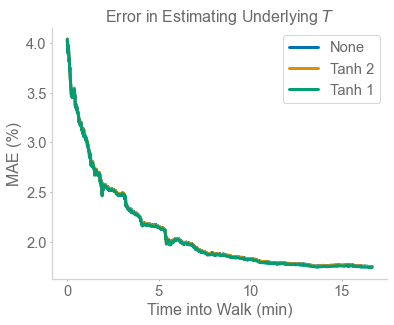

In [21]:
plt.figure(figsize=(6.4*0.9, 4.8))
for idx in range(len(labels)):
    if labels[idx] is not None and 'TD' in labels[idx]: continue
    y = t_errors[idx]*100
    x = np.arange(y.size)/configs.dt_to_sec/60
    plt.plot(
        x, y, label=labels[idx],
        linewidth=3, color=colors[idx]
        )
plt.legend()
plt.xlabel('Time into Walk (min)')
plt.ylabel('MAE (%)')
plt.title('Error in Estimating Underlying $T$')
plt.tight_layout()
#plt.savefig('1f_oja_t_error.png', dpi=300)
plt.show()

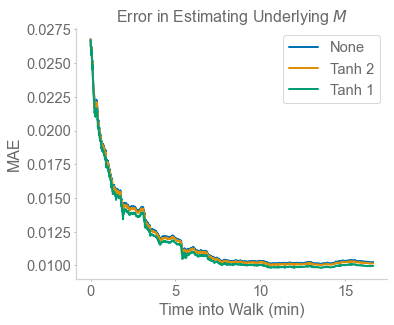

In [22]:
plt.figure(figsize=(6.4*0.9, 4.8))
for idx in range(len(labels)):
    label = labels[idx]
    if label is None:
        continue
    if 'skip' in label:
        label = None
    y = m_errors[idx]
    x = np.arange(y.size)/configs.dt_to_sec/60
    plt.plot(
        x, y, label=label,
        linewidth=2, color=colors[idx]
        )
plt.legend()
plt.xlabel('Time into Walk (min)')
plt.ylabel('MAE')
plt.title('Error in Estimating Underlying $M$')
plt.tight_layout()
#plt.savefig('1f_oja_m_error.png', dpi=300)
plt.show()